In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
import prometheus_api_client as prom
from prometheus_api_client import Metric, MetricsList, PrometheusConnect
from datetime import datetime

In [ ]:
metric_name = ''

In [ ]:
start_time = datetime.fromtimestamp(1580961622)

end_time = datetime.fromtimestamp(1599514864)
label_config = {}
prom_url = 'http://iprometheus.com'
prom_token = ''
prom = PrometheusConnect(url=prom_url,
                         headers={"Authorization": "bearer {}".format(prom_token)},
                         disable_ssl=True)
metric_data = prom.custom_query_range(query=metric_name,
                                      start_time=start_time,
                                      end_time=end_time,
                                      step=6000)

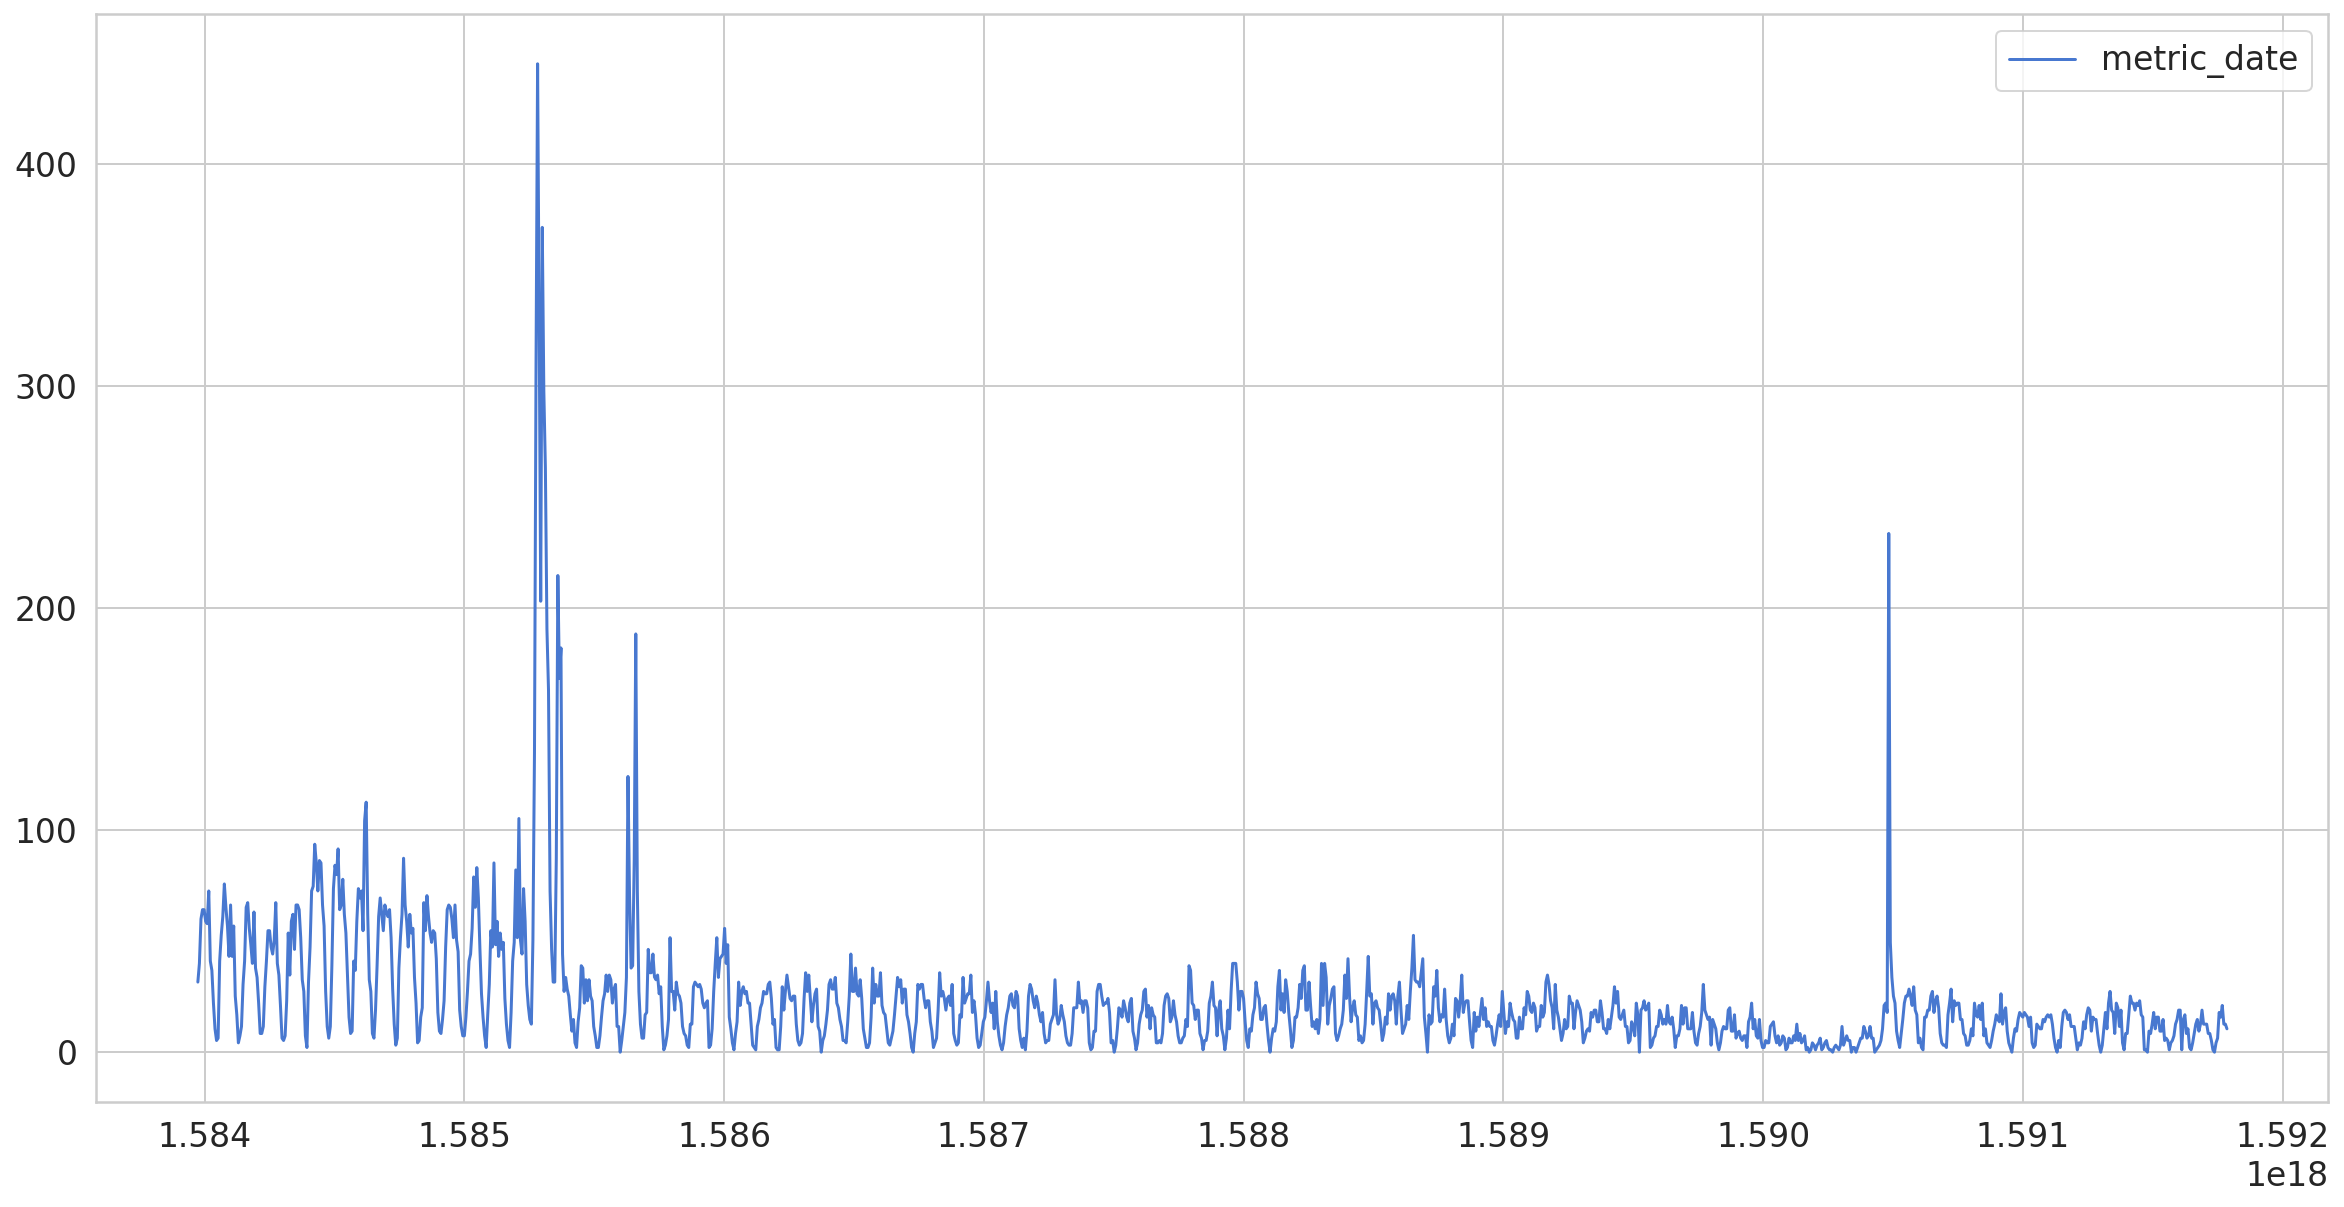

In [ ]:
metrics = MetricsList(metric_data)
metric = metrics[0]
plt.figure(figsize=(20, 10))
plt.plot(metric.metric_values.ds, metric.metric_values.y)
plt.legend(["metric_date"])
plt.show()

In [ ]:
df = metric.metric_values

In [ ]:
df.tail()

,ds,y
1298,2020-06-10 04:00:22,15.789514
1299,2020-06-10 05:40:22,21.052813
1300,2020-06-10 07:20:22,12.631579
1301,2020-06-10 09:00:22,12.631579
1302,2020-06-10 10:40:22,10.526316


In [ ]:
train_size = int(len(df) * 0.85)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(1107, 2) (196, 2)


In [ ]:
# !pip install sklearn

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['y']])

train['y'] = scaler.transform(train[['y']])
test['y'] = scaler.transform(test[['y']])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train[['y']], train.y, TIME_STEPS)
X_test, y_test = create_dataset(test[['y']], test.y, TIME_STEPS)

X_train.shape[1]

30

In [ ]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])))
# model.add(keras.layers.LSTM(units=16))
# model.add(keras.layers.LSTM(units=4, activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
# model.add(keras.layers.LSTM(units=16))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.3,
    shuffle=False,
    verbose=0,
)

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [ ]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

In [ ]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [ ]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

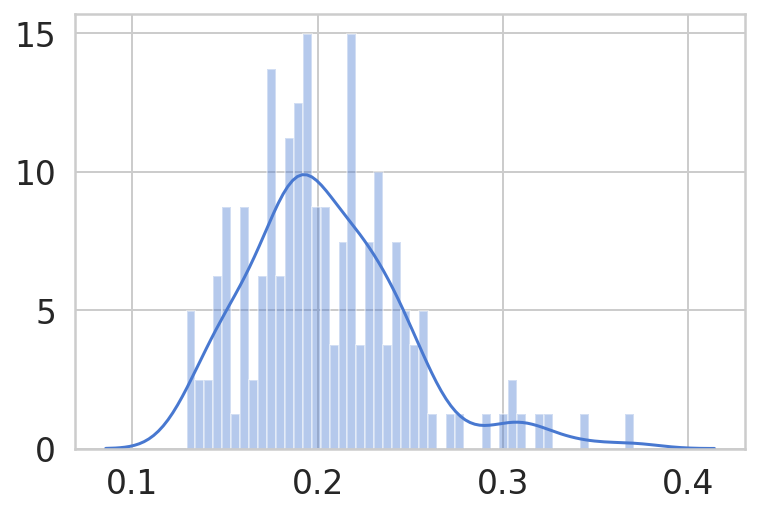

In [ ]:
sns.distplot(test_mae_loss, bins=50, kde=True);

In [ ]:
THRESHOLD = 1.5

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['ds'] = test[TIME_STEPS:].ds
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['y'] = test[TIME_STEPS:].y

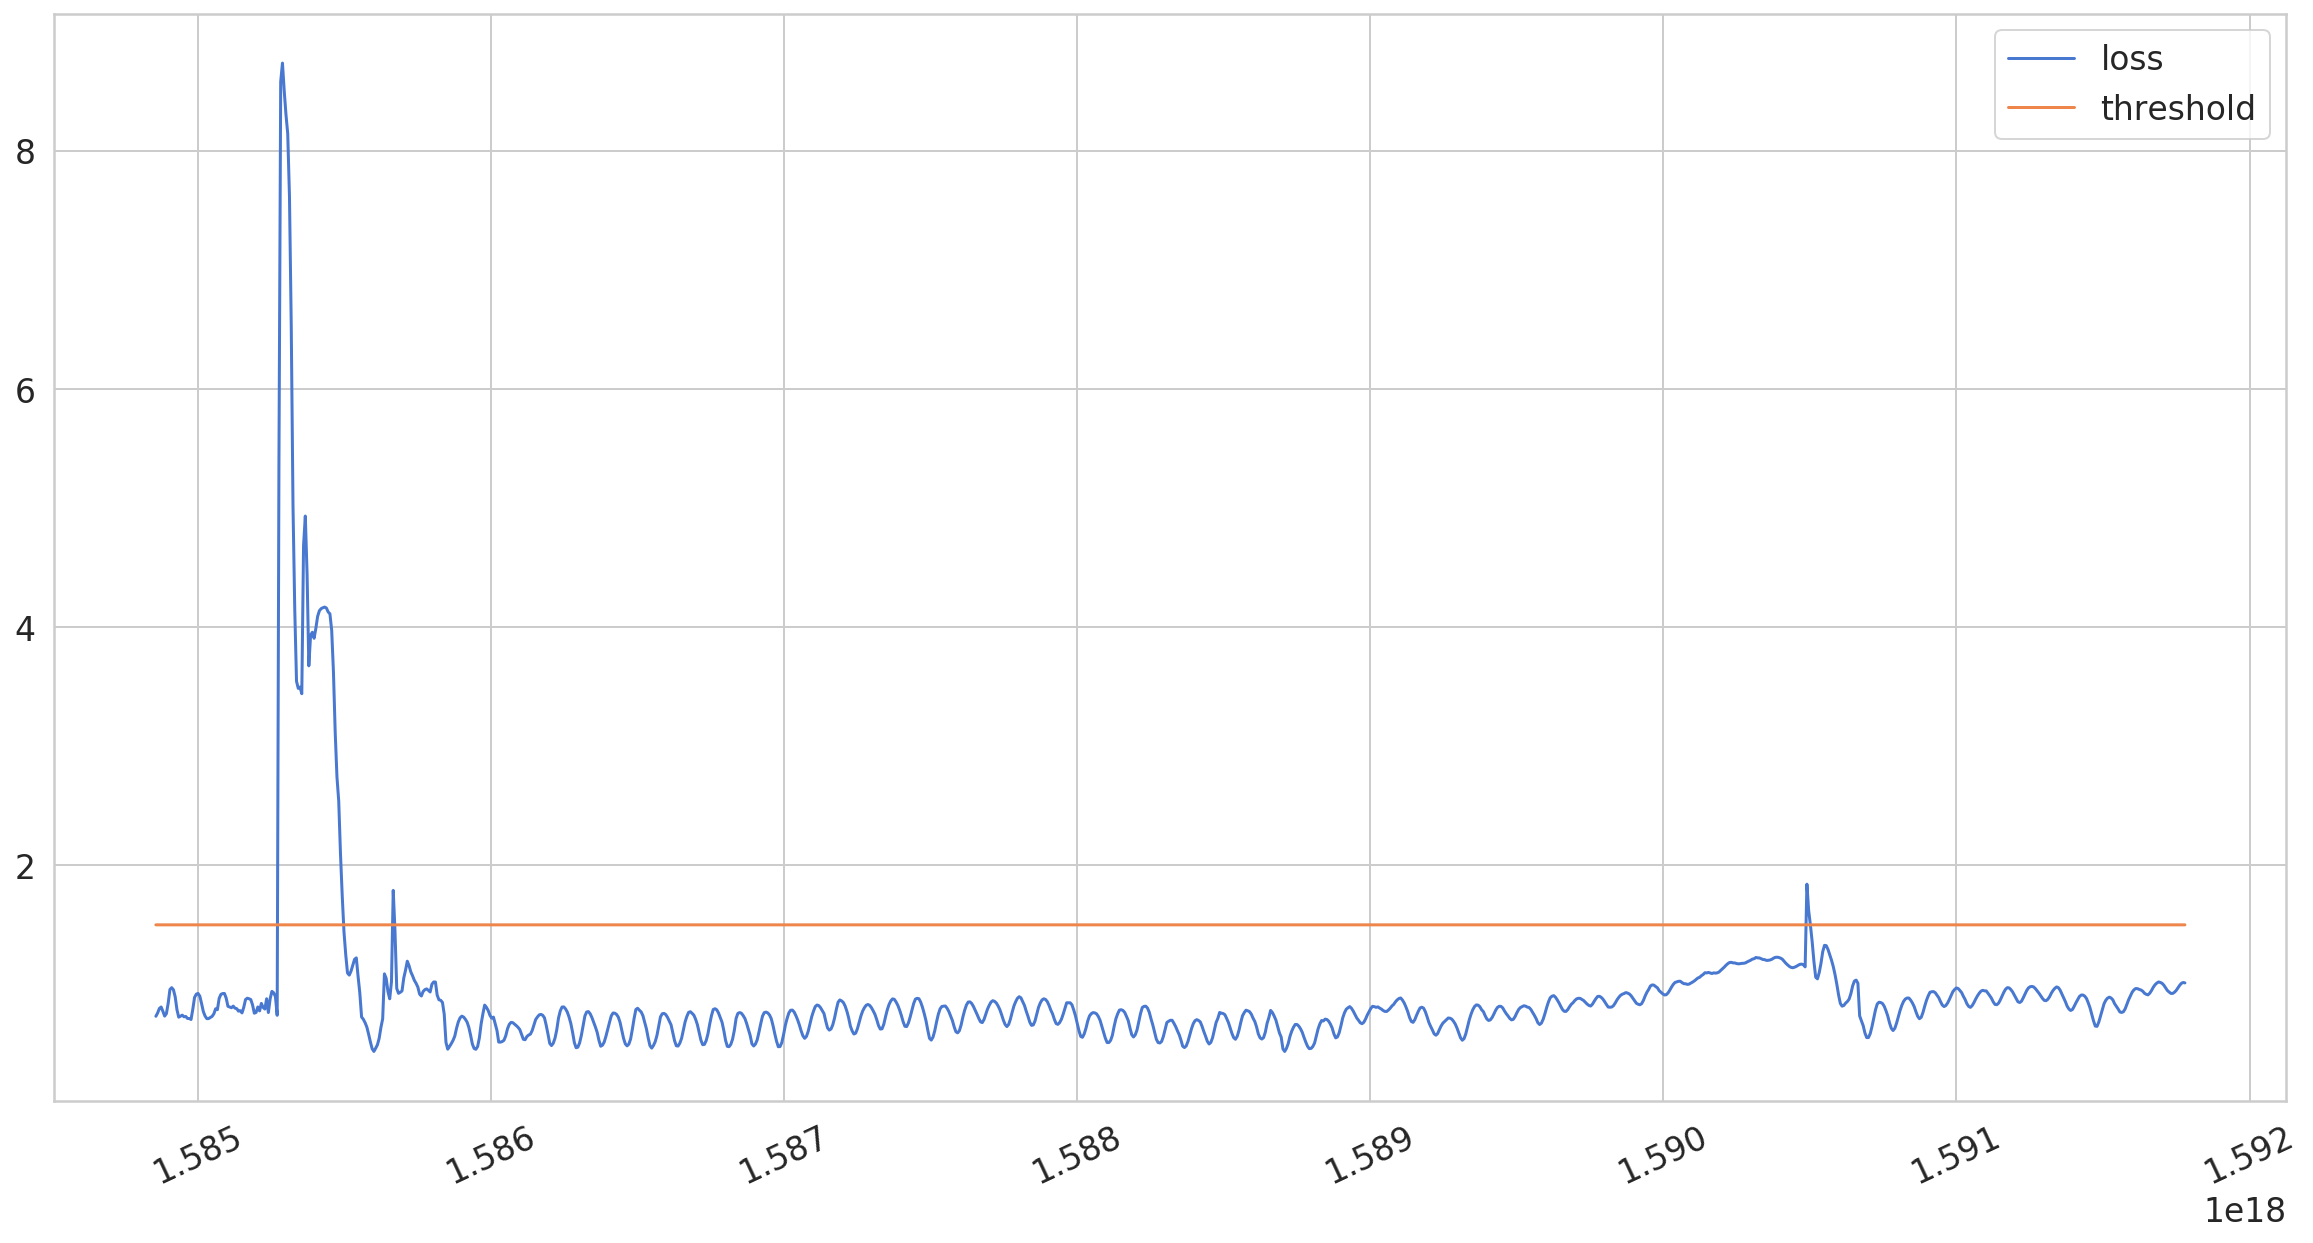

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(test_score_df.ds, test_score_df.loss, label='loss')
plt.plot(test_score_df.ds, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [ ]:
anomalies = test_score_df[test_score_df.anomaly == True]
# anomalies.head(100)

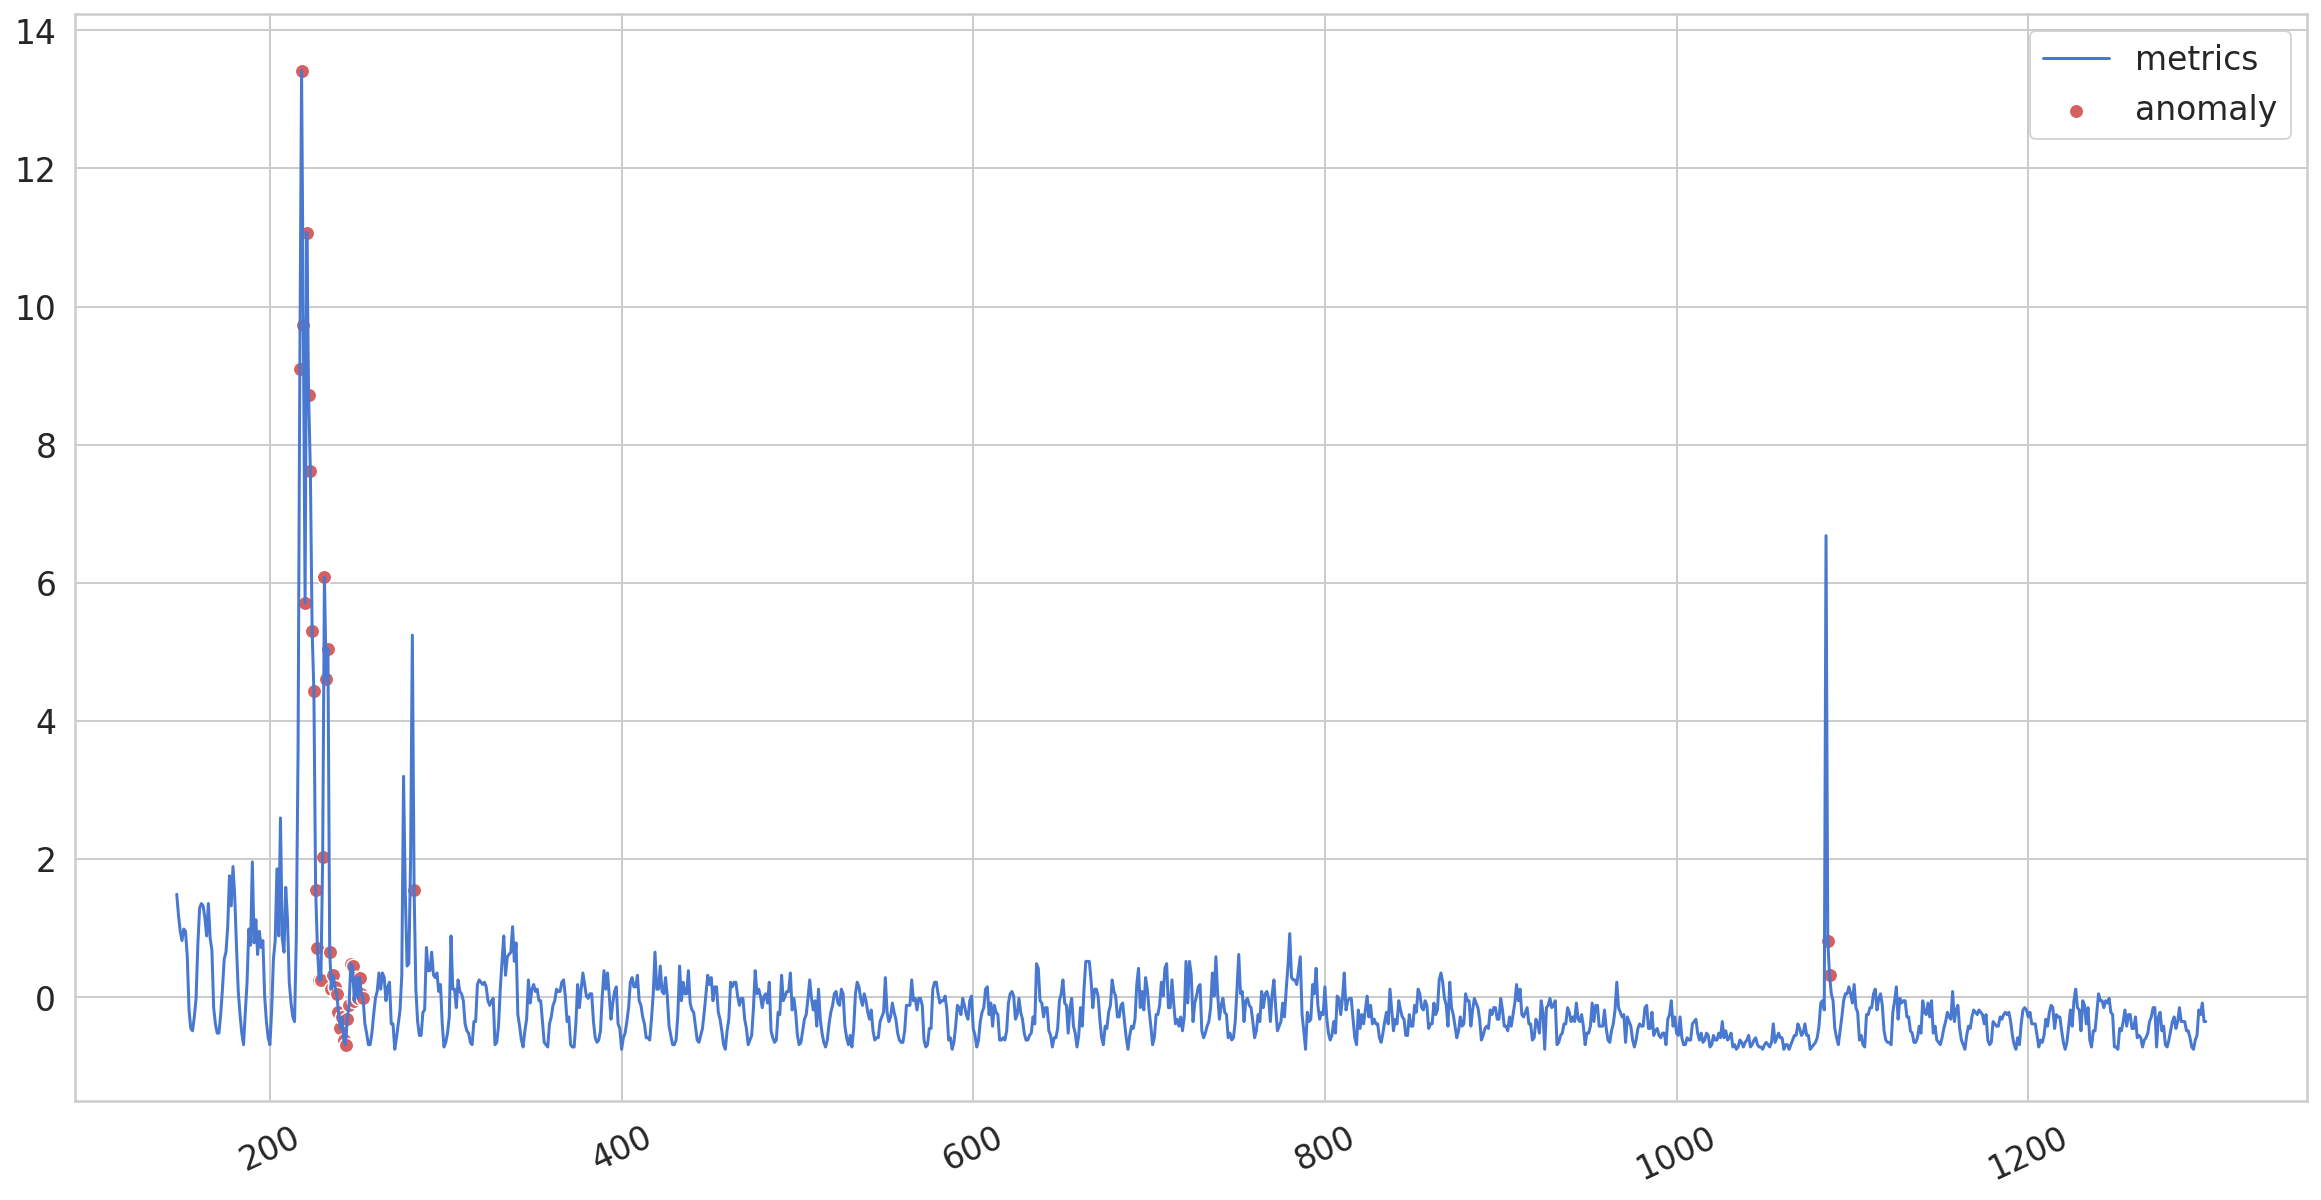

In [ ]:
plt.figure(figsize=(20, 10))

plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].y), 
  label='metrics'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.y),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();